In [1]:
from openai import OpenAI
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
client = OpenAI()

In [3]:
def get_prob(api_response, target_class):
    top_logprobs = api_response.choices[0].logprobs.content[0].top_logprobs
    prob = [np.exp(x.logprob) for x in top_logprobs if x.token == target_class]
    if len(prob) == 0:
        res = 0
    else:
        res = prob[0]
    return res

In [4]:
def gpt_sentimental_classif(text, model):
    system_prompt = """You are an expert in sentiment analysis. 
    You will receive a text that you have to classify. 
    - if the text is positive, then return 'positive'
    - if the text is negative, then return 'negative' 
    Return only 'positive' or 'negative'.
    The output should have 8 characters all in lowercase. 
    No other values are allowed!
    """
    api_response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": text}
        ],
        temperature=0,
        logprobs=True,
        top_logprobs=5
    )
    
    prob_positive = get_prob(api_response, 'positive')
    
    prob_negative = get_prob(api_response, 'negative')

    sum_prob = prob_positive + prob_negative
    prob_positive = prob_positive/sum_prob
    prob_negative = prob_negative/sum_prob

    return prob_positive, prob_negative

In [5]:
def make_exp(model, df):
    res = []
    for i in range(len(df)):
        res.append(gpt_sentimental_classif(df.loc[i, 'reviewText'], model))
    res = pd.DataFrame(res, columns=['prob_positive', 'prob_negative'])
    return res

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/amazon.csv')
df_0 = df[df.Positive == 0].sample(100, random_state=42)
df_1 = df[df.Positive == 1].sample(100, random_state=42)
df = pd.concat([df_0, df_1]).reset_index(drop=True)

In [7]:
prob_gpt_4o = make_exp('gpt-4o', df)
prob_gpt_4o_mini = make_exp('gpt-4o-mini', df)

In [8]:
predictions_gpt_4o = prob_gpt_4o['prob_positive'].apply(lambda x: 1 if x >= 0.5 else 0)
predictions_gpt_4o_mini = prob_gpt_4o_mini['prob_positive'].apply(lambda x: 1 if x >= 0.5 else 0)

In [9]:
accuracy_gpt_4o = (predictions_gpt_4o_mini == df['Positive']).mean()
accuracy_gpt_4o_mini = (predictions_gpt_4o_mini == df['Positive']).mean()
print(f'Accuracy of GPT-3 model: {accuracy_gpt_4o}')
print(f'Accuracy of GPT-4 model: {accuracy_gpt_4o_mini}')

Accuracy of GPT-3 model: 0.96
Accuracy of GPT-4 model: 0.96


In [10]:
fpr_4o, tpr_4o, _ = roc_curve(df['Positive'], prob_gpt_4o['prob_positive'])
roc_auc_4o = auc(fpr_4o, tpr_4o)
fpr_4o_mini, tpr_4o_mini, _ = roc_curve(df['Positive'], prob_gpt_4o_mini['prob_positive'])
roc_auc_4o_mini = auc(fpr_4o_mini, tpr_4o_mini)

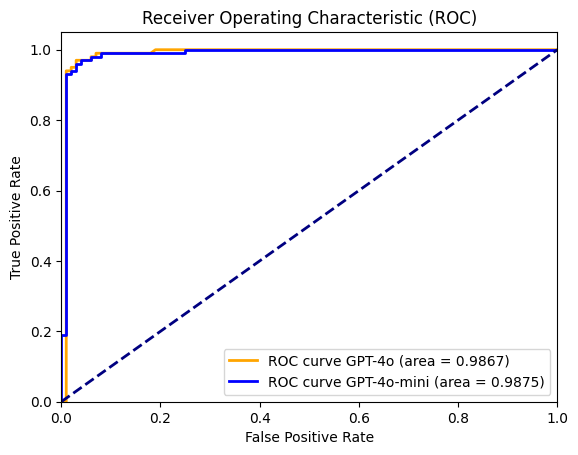

In [11]:
plt.figure()
plt.plot(fpr_4o, tpr_4o, color='orange',
lw=2, label='ROC curve GPT-4o (area = %0.4f)' % roc_auc_4o)
plt.plot(fpr_4o_mini, tpr_4o_mini, color='blue',
lw=2, label='ROC curve GPT-4o-mini (area = %0.4f)' % roc_auc_4o_mini)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()